<a href="https://colab.research.google.com/github/gabrielfernandorey/ITBA-NLP/blob/main/NLP_02_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico NLP - Detección de Tópicos y clasificación
- ITBA 2024
- Alumno: Gabriel Rey
---

### NLP_02_model

Esta notebook se utiliza para:
- armar el modelo de estimación de tópicos
- validar resultados obtenidos
- guardar datos en los indices de opensearch

Esta y las consecuentes notebooks son el desarrollo de base de procesos y funciones para la web app provista.

### MODELO

In [32]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pickle
from datetime import datetime, date, timedelta
from dateutil.parser import parse
from dotenv import load_dotenv

from NLP_tools import *


In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

from tqdm import tqdm

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

In [34]:
from opensearch_data_model import Topic, TopicKeyword, News, os_client, TOPIC_INDEX_NAME, NEWS_INDEX_NAME
from opensearch_io import init_opensearch, get_news, get_entities_news, get_title_news, update_news, get_pos_id
from opensearchpy import helpers

from openai import OpenAI

### Path

In [35]:
load_dotenv()
PATH_REMOTO='/content/ITBA-NLP/data/'
PATH=os.environ.get('PATH_LOCAL', PATH_REMOTO)
PATH

'C:/Users/gabri/OneDrive/Machine Learning/Github/ITBA-NLP/data/'

In [36]:
if PATH == os.environ.get('PATH_LOCAL'):
    if os.environ.get('OPENAI_API_KEY'):
        client = OpenAI(api_key= os.environ.get('OPENAI_API_KEY'))
    else:
        client = None
    print(client)

### Inicializamos la base vectorial

In [37]:
init_opensearch()

Indice Topic creado
El índice News ya existe. Saltando inicialización de base de datos.


### Data de noticias original

In [38]:
# Cargar archivo previamente preprocesado en NLP_01_data 
choice = "20240716"   
df_parquet = pd.read_parquet(PATH+choice+".parquet").reset_index()
data = list(df_parquet['text'])
id_data = list(df_parquet['asset_id'])
title_data = list(df_parquet['title'])

In [39]:
# Cargar vocabulario previamente procesado
with open(PATH+f'preproc_notebook/vocabulary_{choice}.json', 'r') as json_file:
    vocab = json.load(json_file)
len(vocab)

3798

### Preprocesar las noticias
Se realiza un preprocesamiento mínimo del texto, pero no se le quita el sentido semántico para que mediante SentenceTransformer se puedan capturar embeddings de mejor calidad.

In [40]:
# Stopwords
SPANISH_STOPWORDS = list(pd.read_csv(PATH+'spanish_stop_words.csv' )['stopwords'].values)
SPANISH_STOPWORDS_SPECIAL = list(pd.read_csv(PATH+'spanish_stop_words_spec.csv' )['stopwords'].values)

In [41]:
clean_data = Cleaning_text()

proc_data = []
for data_in in tqdm(data):
    aux = clean_data.unicode(data_in)
    aux = clean_data.urls(aux)
    aux = clean_data.simbols(aux)
    aux = clean_data.escape_sequence(aux)
    aux = " ".join([ word for word in aux.split() if word.lower() not in SPANISH_STOPWORDS_SPECIAL])
    proc_data.append(aux)


100%|██████████| 500/500 [00:00<00:00, 928.73it/s]


### Modelo

In [42]:
tfidf_vectorizer = TfidfVectorizer(
        tokenizer=None,
        max_df=0.9,
        min_df=0.1,
        ngram_range=(1, 2),
        vocabulary=vocab,
        # max_features=100_000
)
tfidf_vectorizer.fit(proc_data)

TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 2),
                vocabulary=['Miami Dolphins', 'Juzgado Federal', 'adolescentes',
                            'Congreso Judío Latinoamericano', 'Libertad',
                            'FC Bunge', 'presentación multitudinario',
                            'Policía Federal Argentina', 'Sale',
                            'camiseta blanca', 'Fotos', 'agentes',
                            'Dique Potrerillos', 'temperaturas', 'noviembre',
                            'vistas', 'Pronóstico', 'Celia Cruz', 'San Luis',
                            'Aguas Rionegrinas', 'DEIE', 'sombra',
                            'aniversario', 'Santa Regina', 'encargado',
                            'aeronave', 'Liga Profesional', 'estado físico',
                            'La Libertad Avanza', 'Will Byers', ...])

Capas del modelo BERTopic

In [43]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# Step 4 - Tokenize topics
vectorizer_model = tfidf_vectorizer
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()
# Step 6 - (Optional) Fine-tune topic representations with a `bertopic.representation` model
# representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,              # Step 1 - Extract embeddings
  umap_model=umap_model,                        # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,                  # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,            # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                    # Step 5 - Extract topic words
  # representation_model=representation_model,  # Step 6 - (Optional) Fine-tune topic represenations
  # language='multilingual',                    # This is not used if embedding_model is used.
  verbose=True,
  # calculate_probabilities=True
)

### Datos de Entrenamiento a recuperar

In [44]:
# Cargar modelo entrenado o saltar celda y entrenar
#topic_model = BERTopic.load(PATH+f"modelos_notebook/bertopic_model_{choice}")
#topics = np.load(PATH+f"modelos_notebook/topics_{choice}.npy")
#probs = np.load(PATH+f"modelos_notebook/probs_{choice}.npy")

# Cargar los embeddings
#docs_embedding = np.load(PATH+f"modelos_notebook/docs_embeddings_{choice}.npy")

### Entrenamiento

In [45]:
# Entrenamiento
topics, probs = topic_model.fit_transform(proc_data)

2024-08-28 12:54:49,349 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2024-08-28 12:55:58,667 - BERTopic - Embedding - Completed ✓
2024-08-28 12:55:58,667 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-28 12:56:02,022 - BERTopic - Dimensionality - Completed ✓
2024-08-28 12:56:02,024 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-28 12:56:02,054 - BERTopic - Cluster - Completed ✓
2024-08-28 12:56:02,059 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-28 12:56:02,585 - BERTopic - Representation - Completed ✓


In [46]:
# Obtenemos embeddings de todos los documentos
docs_embedding = topic_model.embedding_model.embed(data)

### Datos de entrenamiento a guardar

In [47]:
# Grabar modelo
topic_model.save(PATH+f"modelos_notebook/bertopic_model_last")
#np.save(PATH+f"modelos_notebook/topics_{choice}.npy", topics)
#np.save(PATH+f"modelos_notebook/probs_{choice}.npy", probs)

# Guardar los embeddings en un archivo de NumPy
np.save(PATH+f"modelos_notebook/docs_embeddings_last.npy", docs_embedding)

2024-08-28 12:57:14,687 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


## Grabar solo resultados del primer modelo en Topic y News
*** El segundo modelo corre en NLP_03_merged, para luego fusionar. ***

### Actualizar datos en news 

In [48]:
# Marcar registros de noticias como procesados y grabar sus embeddings, topicos, probs 
update_news( id_data, docs_embedding, topics, probs )

True

### Grabar todos los registros en Topic y la actualizacion en news

In [49]:
# Grabar todos los topicos en la base
date_choice = choice[:4]+"-"+choice[4:6]+"-"+choice[6:8]

for topic_id in topic_model.get_topics().keys():
    if topic_id > -1:

        topic_keywords_top  = top_keywords(topic_id, topic_model, PATH)
        topic_entities_top  = top_entities(topic_id, topic_model, df_parquet)
        topic_documents_title, threshold  = topic_documents(topic_id, topic_model, df_parquet)
        id_best_doc, title_best_doc, best_doc = best_document(topic_id, topic_model, docs_embedding, id_data, title_data, data)
        

        topic_doc = Topic(
            index = topic_id,
            name =  get_topic_name(''.join(topic_documents_title), topic_id, topic_model, client),
            vector = list(topic_model.topic_embeddings_[topic_id + 1 ]),
            similarity_threshold = threshold,
            created_at = datetime.now(),
            from_date = parse(date_choice),
            to_date = datetime.strptime(date_choice, '%Y-%m-%d') + timedelta(days=1),
            keywords = topic_keywords_top,
            entities = topic_entities_top,
            id_best_doc = id_best_doc,
            title_best_doc = title_best_doc,
            best_doc = best_doc,
        )

        topic_doc.save()



## Resultados y operaciones con el modelo

In [50]:
print(f"Cantidad de tópicos {len(set(topic_model.topics_))} (incluye topico -1)")

Cantidad de tópicos 13 (incluye topico -1)


In [51]:
# Obtener documentos de cada tópico
topic_freq = topic_model.get_topic_freq()

# Imprimir el número de tópicos encontrados (incluyendo el tópico -1)
num_topics = len(topic_freq)
print(f"Número de tópicos encontrados: {num_topics} (incluye el topico -1)")

# Imprimir la cant de documentos de cada tópico
print(topic_freq.to_string(index=False))

Número de tópicos encontrados: 13 (incluye el topico -1)
 Topic  Count
    -1    140
     0    115
     1     73
     2     36
     3     29
     4     19
     5     17
     6     16
     7     12
     8     12
     9     11
    10     10
    11     10


### Recuperar todos los topicos y sus etiquetas generadas por el modelo

In [52]:
topic_labels = topic_model.generate_topic_labels()
topic_labels

['-1_es_em_años',
 '0_años_policía_investigación',
 '1_copa_selección_jugadores',
 '2_actividades_vacaciones_visitantes',
 '3_inteligencia_agencia_agencias',
 '4_merenderos_agua_calle',
 '5_ley_reforma laboral_trabajo',
 '6_dólar_bitcoin_riesgo país',
 '7_temperatura_precipitaciones_variedades',
 '8_caída_toneladas_producción',
 '9_copa_dato confiable_quinta pata',
 '10_sociedades_sociedades anónimas_clubes',
 '11_cementerio_inscriptos_restos']

### Buscar topicos ingresando un texto

In [53]:
topic_res = topic_model.find_topics("cambio climatico")
print(topic_res)
topic_labels[topic_res[0][np.argmax(topic_res[1])]+1]

([7, 8, 4, 6, -1], [0.58300036, 0.27193683, 0.26861697, 0.25462782, 0.2482473])


'7_temperatura_precipitaciones_variedades'

## Elegir un topico para pruebas

In [54]:
# Obtener los n documentos de un tópico
topic_id = np.random.randint(len(set(topic_model.topics_))-1) # Obtener un topico al azar
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )

Topico N°: 5 --> 5_ley_reforma laboral_trabajo


### Buscar los titulos de los primeros n documentos de un topico

In [55]:
n_docs = 5  # N documentos a recuperar
topic_docs_idx = [i for i, (doc, topic) in enumerate(zip(list(df_parquet['title']), topic_model.topics_)) if topic == topic_id]
n_docs = n_docs if n_docs <= len(topic_docs_idx) else len(topic_docs_idx)

print(f"{n_docs} de {len(topic_docs_idx)} titulos de noticias encontrados en el tópico {topic_id:}")
for idx in topic_docs_idx[:n_docs]:
    print("- ",df_parquet.iloc[idx]['title'])

5 de 17 titulos de noticias encontrados en el tópico 5
-  El Gobierno recibe a la CGT para evitar otro paro e intentar acercar posiciones sobre la reforma laboral
-  Primer encuentro por el Consejo de Mayo: el Gobierno recibe hoy al triunvirato de la CGT
-  Con dificultades, Guillermo Francos intenta reunir a toda la oposición para consensuar la agenda parlamentaria
-  Paro docente: Llaryora dijo que harán una nueva propuesta y pedirán la conciliación obligatoria
-  La CGT le planteó al Gobierno dos condiciones para integrar el Consejo de Mayo


#### Busqueda de documentos por topico, ordenados por mayor probabilidad

In [56]:
docs_per_topics = [i for i, x in enumerate(topic_model.topics_) if x == topic_id]
score_docs = topic_model.probabilities_[docs_per_topics]

print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )

reg_data = []
for i, doc in enumerate(docs_per_topics):
    reg_data.append([df_parquet.iloc[doc].asset_id, df_parquet.iloc[doc].title, round(score_docs[i],4)])

df_query = pd.DataFrame(reg_data, columns=['ID','titulo','score'])
print(len(df_query), "docs encontrados")
df_query.sort_values('score', ascending=False).style.set_properties(subset=['titulo'], **{'text-align': 'left'})

Topico N°: 5 --> 5_ley_reforma laboral_trabajo
17 docs encontrados


,ID,titulo,score
0,114827690,El Gobierno recibe a la CGT para evitar otro paro e intentar acercar posiciones sobre la reforma laboral,1.000000
6,114816992,"En busca de básicos por encima del millón de pesos, UTA se reúne con empresas de transporte del interior",1.000000
15,114882117,La CGT se reunió con el Gobierno y pidió que se retire parte de la reforma laboral del DNU,1.000000
12,114878548,La CGT le reclamó al gobierno que eleve el piso de Ganancias y reglamente con precisión la reforma laboral,1.000000
9,114864256,"Un paso más para la ley de Función Pública, con la que se introducen nuevos complementos salariales y evaluaciones a los funcionarios",1.000000
7,114850460,Acindar firmó un incremento salarial del 107% y la UOM levantó la huega,1.000000
8,114882910,La CGT se reunió con el Gobierno: cuáles fueron los principales temas que trataron,1.000000
5,114828214,Fallo ordena pagar las quincenas a tres albañiles que armaron la estructura de un edificio,1.000000
4,114879768,La CGT le planteó al Gobierno dos condiciones para integrar el Consejo de Mayo,1.000000
3,114846558,Paro docente: Llaryora dijo que harán una nueva propuesta y pedirán la conciliación obligatoria,1.000000


### Criterio de corte (umbral)
El criterio de corte utilizado para filtrar las noticias que pertenecen a un topico es la "media"

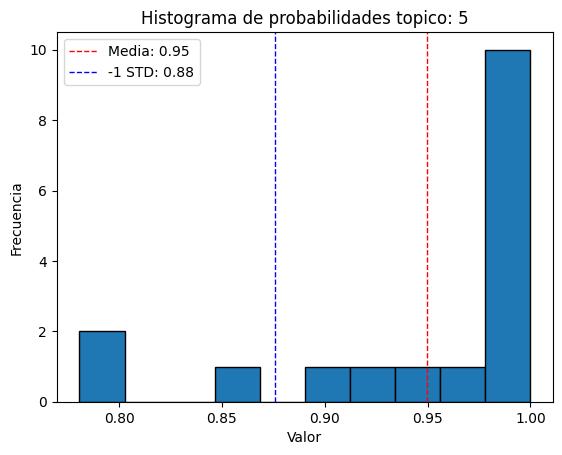

In [57]:
# Calcular la media, el desvío estándar

mean = np.mean([fila[2] for fila in reg_data])
std_dev = np.std([fila[2] for fila in reg_data])

# Crear el histograma
plt.hist([fila[2] for fila in reg_data], bins=10, edgecolor='black')

# Añadir líneas para la media, la moda y el desvío estándar
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'Media: {mean:.2f}')
plt.axvline(mean - std_dev, color='b', linestyle='dashed', linewidth=1, label=f'-1 STD: {mean - std_dev:.2f}')


# Añadir títulos y etiquetas
plt.title(f'Histograma de probabilidades topico: {topic_id}')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

In [58]:
# Definir la función de estilo
def color_rows(row, label, value):
    if row[label] >= value:
        return ['color: cyan'] * len(row)
    else:
        return [''] * len(row)

# Calcular la media
threshold = df_query.score.mean()

print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
print(f"Umbral de corte {threshold}")

df_query.sort_values('score', ascending=False, inplace=True)
df_query.style.apply(lambda row: color_rows(row, 'score', threshold), axis=1).set_properties(subset=['titulo'], **{'text-align': 'left'})

Topico N°: 5 --> 5_ley_reforma laboral_trabajo
Umbral de corte 0.9499705882352941


,ID,titulo,score
0,114827690,El Gobierno recibe a la CGT para evitar otro paro e intentar acercar posiciones sobre la reforma laboral,1.000000
6,114816992,"En busca de básicos por encima del millón de pesos, UTA se reúne con empresas de transporte del interior",1.000000
15,114882117,La CGT se reunió con el Gobierno y pidió que se retire parte de la reforma laboral del DNU,1.000000
12,114878548,La CGT le reclamó al gobierno que eleve el piso de Ganancias y reglamente con precisión la reforma laboral,1.000000
9,114864256,"Un paso más para la ley de Función Pública, con la que se introducen nuevos complementos salariales y evaluaciones a los funcionarios",1.000000
7,114850460,Acindar firmó un incremento salarial del 107% y la UOM levantó la huega,1.000000
8,114882910,La CGT se reunió con el Gobierno: cuáles fueron los principales temas que trataron,1.000000
5,114828214,Fallo ordena pagar las quincenas a tres albañiles que armaron la estructura de un edificio,1.000000
4,114879768,La CGT le planteó al Gobierno dos condiciones para integrar el Consejo de Mayo,1.000000
3,114846558,Paro docente: Llaryora dijo que harán una nueva propuesta y pedirán la conciliación obligatoria,1.000000


#### Documentos mas representativos de un topico

- [1]  Desde el metodo del modelo

In [59]:
docs_representative = topic_model.get_representative_docs(topic=topic_id)
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
docs_representative

Topico N°: 5 --> 5_ley_reforma laboral_trabajo


['Dos de los tres dirigentes de la CGT se reunieron con el Secretario de Trabajo para reclamar que se revise el piso de Ganancias y que se retire parte del DNU en relación a la reforma laboral Convocados por el Gobierno dos miembros del triunvirato que lidera la Confederación General de Trabajo CGT se reunieron este martes a las 13 en la sede de la Secretaría de Trabajo para reclamar la revisión de los puntos de la reforma laboral y del piso del pago del impuesto a las Ganancias entre otros temas Vamos a solicitarle que retire parte del DNU buen gesto Vamos a plantear las incoherencias de un texto muy mal escrito anunció Héctor Daer antes de entrar a la reunión con Carlos Acuña por parte de la CGT y con el titular de Trabajo Julio Cordero cara del Gobierno Sin la participación de Pablo Moyano los triunviros dialoguistas insistieron en la necesidad de que el Gobierno desista del apartado laboral del DNU de diciembre de 2023 que no está en vigencia debido a la presentación judicial de la

- [2] Por similitud coseno del topico a los tres documento mas cercanos

In [60]:
# Obtenemos la matriz de similitud coseno entre topicos y documentos
sim_matrix = cosine_similarity(topic_model.topic_embeddings_, docs_embedding)
sim_matrix.shape

(13, 500)

In [61]:
# Similitud coseno entre el topico y los documentos del topico elegido
s_coseno = []
for i in docs_per_topics:
    s_coseno.append(cosine_similarity([topic_model.topic_embeddings_[topic_id + 1]], [docs_embedding[i]])[0][0])

# Indices
idx_coseno_sort = np.argsort(s_coseno)[::-1]

print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )

for idx in idx_coseno_sort[:3]:
    print(idx, df_parquet.iloc[docs_per_topics[idx]].title)


Topico N°: 5 --> 5_ley_reforma laboral_trabajo
8 La CGT se reunió con el Gobierno: cuáles fueron los principales temas que trataron
0 El Gobierno recibe a la CGT para evitar otro paro e intentar acercar posiciones sobre la reforma laboral
9 Un paso más para la ley de Función Pública, con la que se introducen nuevos complementos salariales y evaluaciones a los funcionarios


- [3] Primer documento mas cercano al embedding del topico

In [62]:
# Documento de maxima similitud con el topico

simil_docs_topic = sim_matrix[topic_id+ 1].argmax()
print(f"Noticia de maxima similitud con el topico: {topic_id}")
print(f"Doc ID: {df_parquet.index[simil_docs_topic]}")
print(f"Titulo: {df_parquet.iloc[simil_docs_topic].title}")
best_doc = data[simil_docs_topic]

Noticia de maxima similitud con el topico: 5
Doc ID: 270
Titulo: La CGT se reunió con el Gobierno: cuáles fueron los principales temas que trataron


#### Keywords de un topico (modelo)

In [63]:
# Obtener las palabras clave para un topico dado
topic_keywords = topic_model.get_topic(topic_id)
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
print(topic_keywords)

Topico N°: 5 --> 5_ley_reforma laboral_trabajo
[('ley', 0.08245241915831054), ('reforma laboral', 0.07461784397199081), ('trabajo', 0.068597288734888), ('trabajadores', 0.05942632711064971), ('impuesto', 0.05822546706153823), ('central obrera', 0.05596016274610773), ('gobierno', 0.05040611461608377), ('reforma', 0.04999193554441989), ('reunión', 0.0412411796698818), ('mayo', 0.040234227138189485)]


#### Keywords de un topico (otra forma de obtenerlos)

In [64]:
keywords = topic_model.topic_representations_[topic_id]
topic_keywords = [TopicKeyword(name=keyword, score=score) for keyword, score in keywords if keyword != '']
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
topic_keywords

Topico N°: 5 --> 5_ley_reforma laboral_trabajo


[{'name': 'ley', 'score': 0.08245241915831054},
 {'name': 'reforma laboral', 'score': 0.07461784397199081},
 {'name': 'trabajo', 'score': 0.068597288734888},
 {'name': 'trabajadores', 'score': 0.05942632711064971},
 {'name': 'impuesto', 'score': 0.05822546706153823},
 {'name': 'central obrera', 'score': 0.05596016274610773},
 {'name': 'gobierno', 'score': 0.05040611461608377},
 {'name': 'reforma', 'score': 0.04999193554441989},
 {'name': 'reunión', 'score': 0.0412411796698818},
 {'name': 'mayo', 'score': 0.040234227138189485}]

### Top keywords de un topico

In [65]:
# Calculo de umbral de corte para las keywords
def keywords_umbral(topic_keywords):
    freq_k = []
    for name_score in topic_keywords:
        freq_k.append(name_score['score'])
    umbral_k = np.array(freq_k).mean()
    print(f"umbral keywords: {umbral_k}")

    topic_keywords_top = {}
    for name_score in topic_keywords:
        if name_score['score'] >= umbral_k:
            topic_keywords_top[name_score['name']] = name_score['score']

    return topic_keywords_top

keywords_umbral(topic_keywords)

umbral keywords: 0.058115296575206


{'ley': 0.08245241915831054,
 'reforma laboral': 0.07461784397199081,
 'trabajo': 0.068597288734888,
 'trabajadores': 0.05942632711064971,
 'impuesto': 0.05822546706153823}

### Top Entities de un topico

In [66]:
threshold = df_query.score.mean()
print(f"umbral entities: {threshold}")

entities_topic = []
for doc_ID in list(df_query[df_query["score"] > threshold]['ID']):
    entities_topic.append(get_entities_news(doc_ID))

# Crear un diccionario para contar en cuántos documentos aparece cada palabra
document_frequencies = defaultdict(int)

# Crear un conjunto para cada documento y contar las palabras únicas
for lista in entities_topic:
    unique_words = set(lista)
    for palabra in unique_words:
        document_frequencies[palabra] += 1

# Ordenar las palabras por la frecuencia de documentos de mayor a menor
sorted_frequencies = sorted(document_frequencies.items(), key=lambda item: item[1], reverse=True)

# Calcular el umbral
freq_e = [item[1] for item in sorted_frequencies]
umbral_e = np.mean(freq_e)

# Obtener el resultado ordenado de las primeras 10 entidades segun criterio de corte
topic_entities_top = {}
c=0
for idx in range(len(sorted_frequencies)):
    if sorted_frequencies[idx][1] >= umbral_e:
        if c != 10:
            topic_entities_top[sorted_frequencies[idx][0]] = sorted_frequencies[idx][1]
        else:
            break
        c += 1 

    elif len(topic_entities_top) <= 3:
        topic_entities_top[sorted_frequencies[idx][0]] = sorted_frequencies[idx][1]

topic_entities_top



umbral entities: 0.9499705882352941


{'Javier Milei': 4,
 'Ganancias': 4,
 'Gobierno': 4,
 'CGT': 3,
 'Héctor Daer': 3,
 'Julio Cordero': 2,
 'Gobierno nacional': 2,
 'Corte': 2,
 'agregó Daer': 2,
 'Carlos Acuña': 2}

### Obtener los titulos de noticias del topico filtrado por umbral de corte 

In [67]:
topic_documents_title, threshold = topic_documents(topic_id, topic_model, df_parquet)
print(threshold)
topic_documents_title

0.9499705882352941


['El Gobierno recibe a la CGT para evitar otro paro e intentar acercar posiciones sobre la reforma laboral',
 'En busca de básicos por encima del millón de pesos, UTA se reúne con empresas de transporte del interior',
 'La CGT se reunió con el Gobierno y pidió que se retire parte de la reforma laboral del DNU',
 'La CGT le reclamó al gobierno que eleve el piso de Ganancias y reglamente con precisión la reforma laboral',
 'Un paso más para la ley de Función Pública, con la que se introducen nuevos complementos salariales y evaluaciones a los funcionarios',
 'Acindar firmó un incremento salarial del 107% y la UOM levantó la huega',
 'La CGT se reunió con el Gobierno: cuáles fueron los principales temas que trataron',
 'Fallo ordena pagar las quincenas a tres albañiles que armaron la estructura de un edificio',
 'La CGT le planteó al Gobierno dos condiciones para integrar el Consejo de Mayo',
 'Paro docente: Llaryora dijo que harán una nueva propuesta y pedirán la conciliación obligatoria

### Generar un nombre de topico con LLM ( Open AI)
- Validar OPENAI_API_KEY en .env

In [68]:
for topic_id in topic_model.get_topics().keys():
    if topic_id > -1:
        topic_documents_title, threshold  = topic_documents(topic_id, topic_model, df_parquet)        
        print(f"{topic_id} {get_topic_name(''.join(topic_documents_title), topic_id, topic_model, client)}")

0 Actualidad y sucesos impactantes.
1 Crisis y cambios en Boca Juniors
2 Actividades culturales en vacaciones
3 Reestructuración de servicios de inteligencia
4 Problemas sociales y servicios públicos
5 Negociaciones laborales y reformas sociales
6 Mercados financieros y criptomonedas.
7 Pronóstico del clima en Argentina
8 Crisis económica y agrícola actual
9 Impacto del Pacto de Mayo en Neuquén
10 Transformación de clubes en SAD
11 Iniciativas y proyectos comunitarios locales


### Recuperar todos los topicos desde el indice Topic de la base

In [69]:
index_name = 'topic'

topics_list = []
for i, doc in enumerate(Topic.search().query().scan()):
    topics_list.append(doc.to_dict())
    print(topics_list[i]['index'], topics_list[i]['name'])

0 Actualidad y sucesos impactantes.
1 Crisis y cambios en Boca Juniors
2 Actividades culturales en invierno
3 Reestructuración de servicios de inteligencia
4 Problemas sociales y servicios básicos
5 Negociaciones laborales y reformas gubernamentales
6 Mercados financieros y criptomonedas.
7 Pronóstico del clima en Argentina
8 Impacto económico en la agricultura
9 Impacto del Pacto de Mayo en Neuquén
10 Transformación de clubes deportivos
11 Iniciativas comunitarias y desarrollo local


### Busqueda de 5 documentos del indice news de la base correspondiente a un topico
** (devuelve los docs que han sido marcados en el campo process en True )

In [70]:
topic_id = np.random.randint(len(set(topic_model.topics_))-1) # Obtener un topico al azar
print(f"Topico N°: {topic_id} --> {topics_list[topic_id]['name']}" )

Topico N°: 9 --> Impacto del Pacto de Mayo en Neuquén


In [71]:
topic_embedding = topics_list[topic_id]['vector']

index_name = 'news'
# Crear una consulta KNN para buscar embeddings cercanos
knn_query = {
    "size": 5,  # Número de resultados que deseas obtener
    "query": {
        "bool": {
            "must": [
                {
                    "knn": {
                        "vector": {
                            "vector": topic_embedding,
                            "k": 10  # Número de vecinos más cercanos
                        }
                    }
                },
                {
                    "term": {
                        "process": True  # Solo incluir documentos donde 'process' es True
                    }
                }
            ],
            "filter": {
                "exists": {
                    "field": "vector"  # Solo incluir documentos que tienen el campo 'vector'
                }
            }
        }
    }
}
# Realizar la búsqueda
response_topic = os_client.search(index=index_name, body=knn_query)

# Obtener el tópico más cercano
print(f"Topico N°: {topic_id} --> {topics_list[topic_id]['name']}" )

if response_topic['hits']['total']['value'] > 0:
    for i in [hit['_source']['title'] for hit in response_topic['hits']['hits']]:
        print(i)
else:
    print("No se encontraron documentos cercanos al topico dado.")

Topico N°: 9 --> Impacto del Pacto de Mayo en Neuquén
La insólita explicación de Riquelme sobre la polémica en Boca
El Gobierno anunció superávit financiero por sexto mes consecutivo
La insólita explicación de Riquelme sobre la polémica por los refuerzos en Boca
Qué son las SAD y qué cambios implican para los clubes deportivos del país
La Voz -Martes 16/07/2024


### Nuevo documento consultando embeddings generados por el modelo

In [72]:
new_doc = "Fuga de presos en San Telmo"

new_doc_embedding = topic_model.embedding_model.embed(new_doc)
sim_matrix_new = cosine_similarity(topic_model.topic_embeddings_, new_doc_embedding.reshape(1, -1))

idx = np.argmax(sim_matrix_new)-1         # Topicos desde -1, 0, 1, ..., n
print(f"Topico N°: {topics_list[idx]['index']} --> {topics_list[idx]['name']}" )

Topico N°: 0 --> Actualidad y sucesos impactantes.


### Nuevo documento consultando embeddings de la base

In [73]:
new_doc = "Fuga de presos en San Telmo"

new_doc_embedding = topic_model.embedding_model.embed(new_doc)

# Buscamos en la base a que topico pertenece el nuevo documento
knn_query = {
    "size": 1,
    "query": {
        "knn": {
            "vector": {
                "vector": new_doc_embedding,
                "k" : 3
            }
        }
    }
}
response = os_client.search(index='topic', body=knn_query)

if response['hits']['total']['value'] > 0:
    print(f"Topico: {response['hits']['hits'][0]['_source']['name']}")
    print(f"Estimacion: {response['hits']['hits'][0]['_score']}")
else:
    print(f"Topico no encontrado")

Topico no encontrado


### Graficar los topicos en 3d

In [74]:
import plotly.express as px

# Obtener los embeddings de los tópicos
topic_embeddings = topic_model.topic_embeddings_

new_doc = "Fuga de presos en San Telmo"  # nuevo texto
new_doc_embedding = topic_model.embedding_model.embed([new_doc])[0] # embedding de nuevo texto

total = np.vstack((topic_embeddings, new_doc_embedding))

# Reducir la dimensionalidad de los embeddings a 3D usando UMAP
umap_model = UMAP(n_components=3)
embeddings_3d = umap_model.fit_transform(total)

# Obtener las etiquetas de los tópicos
topics_labels = [str(i)+" "+name['name'][:50] for i, name in enumerate(topics_list) ]

# Crear un DataFrame para Plotly
df_plotly = pd.DataFrame(embeddings_3d, columns=['Dim1', 'Dim2', 'Dim3'])
df_plotly['Topico'] = ["-1"] + topics_labels + ['>>'+new_doc[:15]] # Identificamos el nuevo documento
df_plotly['Etiqueta'] = list(range(-1, len(topic_embeddings)-1)) + [new_doc[:15]]

# Graficar los tópicos en 3D de manera interactiva usando Plotly, ajustando el tamaño del gráfico
fig = px.scatter_3d(df_plotly, x='Dim1', y='Dim2', z='Dim3', color='Topico', text='Etiqueta', title='Visualización 3D de Tópicos con BERTopic')


# Ajustar el tamaño del gráfico
fig.update_layout(
    autosize=False,
    width=1200,  # Ancho del gráfico
    height=800,  # Altura del gráfico
    margin=dict(l=65, r=50, b=65, t=90)
)

# Mostrar el gráfico
fig.show()

#### Agrupando por embeddings cercanos

In [75]:
# Eliminamos el topico -1
new_topic_embeddings = topic_embeddings[1:]

# Calcular la similitud del coseno entre los embeddings de los tópicos
similarities = cosine_similarity(new_topic_embeddings)

# Crear una matriz de similitud excluyendo la diagonal
np.fill_diagonal(similarities, 0)

# Encontrar los pares de tópicos más cercanos
topic_pairs = np.dstack(np.unravel_index(np.argsort(similarities.ravel())[::-1], similarities.shape))[0]

# Mostrar los 5 pares de tópicos más cercanos
for i in range(10):
    topic_id_1, topic_id_2 = topic_pairs[i]
    similarity_score = similarities[topic_id_1, topic_id_2]
    print(f"Topico {topic_id_1} y Topico {topic_id_2} tienen una similitud de: {similarity_score:.4f}")

Topico 11 y Topico 4 tienen una similitud de: 0.7760
Topico 4 y Topico 11 tienen una similitud de: 0.7760
Topico 5 y Topico 11 tienen una similitud de: 0.7438
Topico 11 y Topico 5 tienen una similitud de: 0.7438
Topico 3 y Topico 5 tienen una similitud de: 0.6840
Topico 5 y Topico 3 tienen una similitud de: 0.6840
Topico 0 y Topico 1 tienen una similitud de: 0.6596
Topico 1 y Topico 0 tienen una similitud de: 0.6596
Topico 11 y Topico 2 tienen una similitud de: 0.6447
Topico 2 y Topico 11 tienen una similitud de: 0.6447
